# Minimum Energy Path

## Data
The output from FIREBALL has an xyz file which contains the position of each atom at each step and an energy file which contains eigen values for all the Kohn-Sham states. Using these outputs one can calculate all the important features in a molecules, in this case we have calculated all the bond lengths, angles and dihedrals. 
Next each data point is saved as a vector which contains all the desired features. All of these data points (each point is a step in simulation, also multiple simulations can be used to have an ensemble of different orientations of a molecule) are saved in a matrix $X$. Parallel to that all the desired energy values are saved in another column vector $Y$.

So far we have a matrix $X_{ij}$, where $i$ represents the orientation of the molecule (one step in one simulation) and $j$ represents the feature (bond,angle or dihedral), and we have a column vector $Y_i$ which represent the energy for orientation $i$.

The preperation of data has been done in another script. 

In [1]:
import numpy as np
#%matplotlib notebook
import matplotlib.pylab as plt
import h5py
import os



In [2]:
def PPCA(data):
    import numpy as np
    from scipy import linalg as la
    nr ,nc = data.shape
    R = np.cov(data,rowvar=False)
    evals, evecs = la.eigh(R)
    idx = np.argsort(evals)[::-1]
    evecs = evecs[:,idx]
    evals = evals[idx]
    return np.dot(evecs.T,data.T).T,evals,evecs

In [3]:
f = h5py.File("MY_DATA50.hdf5","r") 

In [4]:
for name in f:
    print(name)

Data
Eigen_Values
Features
Occupancy


In [5]:
X = np.array(f.get("Data"))
Y = np.array(f.get("Eigen_Values"))
features = np.array(f.get("Features"))
occupancy = np.array(f.get("Occupancy"))

In [6]:
ndata = len(X)
idx_exc = occupancy[:,1] == 1
idx_rlx = np.bitwise_not(idx_exc)
Y_HOMO_EXC = Y[idx_exc,0]
Y_LUMO_EXC = Y[idx_exc,1]
X_EXC = X[idx_exc]
Y_HOMO_RLX = Y[idx_rlx,0]
Y_LUMO_RLX = Y[idx_rlx,1]
X_RLX = X[idx_rlx]

In [8]:
X_RLX.shape

(331144, 116)

In [10]:
Y_HOMO_RLX.shape

(331144,)

# Feature selection
In order to have an indirect calculation minimum energy path (MEP), one has to find the transition cooridinate, this coordinate might be a dihedral angle (in azobenzene), or a bond lenght(in dirylethene), or an angle. To find the transition coordinate we can use different feature selection methods from machine learning and statistical science. 
## Mutual Information Regresion
This function estimate mutual information for a continuous target variable.
Mutual information(MI) calculates the dependency of two random variables. more specifically it is a measure of information obtain about one variable using the other one. The amount of information about a vairable is described as entropy in Information Science. MI can be measured with the following formula for continues variables:

$MI(X,Y) = \int_X \int_Y p(x,y)log_2 (\frac{p(x,y)}{p(x)p(y)})dx dy $,


The result of MI start from 0, meaning zero dependence between that specific feature and the enrgy and increases as the depepndence increases.

The following will be done on the results of both relaxed HOMO and LUMO.

In [13]:
from sklearn.feature_selection import f_regression, mutual_info_regression

In [11]:
if os.path.exists("MI.hdf5"):
    f2 = h5py.File("MI.hdf5","r")
    mi_RLX = np.array(f2.get("MI"))
    features = np.array(f2.get("features"))
else : 
    mi_RLX = mutual_info_regression(X_RLX, Y_HOMO_RLX)
    f2 = h5py.File("MI.hdf5")
    dset1 = f2.create_dataset("MI",mi_RLX.shape,dtype = "f")
    dset2 = f2.create_dataset("features",features.shape,dtype = "|S26")
    dset1[:] = mi_RLX[:]
    dset2[:] = features[:]

In [14]:
mi_RLX = mutual_info_regression(X_RLX, Y_HOMO_RLX)

In [15]:
mi_RLX

array([ 0.02054568,  0.01371279,  0.02271024,  0.02257773,  0.01915477,
        0.01804723,  0.02077242,  0.02129671,  0.0163955 ,  0.0177271 ,
        0.01216713,  0.01844619,  0.04381208,  0.04613543,  0.06064286,
        0.00874813,  0.00882771,  0.01239637,  0.00649782,  0.00955645,
        0.00843398,  0.01232404,  0.0105054 ,  0.00822631,  0.00734254,
        0.01935669,  0.01562819,  0.01430853,  0.0189044 ,  0.01385938,
        0.01458604,  0.02373914,  0.01670042,  0.01641443,  0.03484688,
        0.03719254,  0.03426304,  0.02783541,  0.0172256 ,  0.01773075,
        0.01876258,  0.01611968,  0.01491667,  0.02833941,  0.01877401,
        0.01575325,  0.03443842,  0.03779705,  0.03834385,  0.02560926,
        0.01587738,  0.01833894,  0.01686461,  0.01860651,  0.01551146,
        0.0218259 ,  0.0167638 ,  0.01519595,  0.02072284,  0.01767905,
        0.01522941,  0.10492295,  0.09718293,  0.01510776,  0.01288036,
        0.01089537,  0.01360729,  0.01449273,  0.01496314,  0.01

In [12]:
for i in range(len(features)):
    print(features[mi_RLX.argsort()][i].decode("utf-8"),mi_RLX[mi_RLX.argsort()][i])

H18C10 0.00649782
H24C5 0.00734432
H17C11C10C9 0.00780179
H23C6 0.00822777
H20C3 0.00843036
H15C7 0.00874922
H16C12 0.00882755
H17C11C10H18 0.00924178
H18C10C9H19 0.00931699
H19C9 0.00955638
H22C1 0.0105048
H23C6C5H24 0.0105708
H16C12C11H17 0.0105859
H21C2C1C6 0.010896
H23C6C1H22 0.0113321
C5C6C1H22 0.0115414
H20C3C2C1 0.0115941
C11C12C7H15 0.0119094
H19C9C8C7 0.0121297
C12C7 0.0121632
H21C2 0.0123256
H17C11 0.0123969
H23C6C5C4 0.0124801
H20C3C2H21 0.0126008
C9C8C7H15 0.012708
H16C12C7H15 0.012729
C3C2C1H22 0.0128829
C7C12C11C10 0.012992
H18C10C9C8 0.0130058
C1C6C5H24 0.0133531
C7C12C11H17 0.0135995
H21C2C1H22 0.0136079
C3C2 0.0137178
C1C2H21 0.0138582
C6C5C4C3 0.0138785
C5C6C1C2 0.0138933
H24C5C4C3 0.0141487
C11C12C7C8 0.0142726
C6C1H22 0.0143104
C4C3C2C1 0.014492
C3C2H21 0.0145846
C12C11C10H18 0.0146158
C11C10C9C8 0.0148083
H16C12C11C10 0.0148605
H16C12C7C8 0.0149006
C5C6H23 0.0149137
C4C3C2H21 0.0149628
C3C2C1C6 0.0151076
C12C11H17 0.0151976
C11C12H16 0.0152283
H23C6C1C2 0.0153498
C

In [13]:
cond1 = np.bitwise_and((mi_RLX>0.097),(mi_RLX<0.104))
cond2 = np.bitwise_and((mi_RLX>0.104),(mi_RLX<0.114))
cond3 = np.bitwise_and((mi_RLX>0.114),(mi_RLX<0.124))
cond4 = np.bitwise_and((mi_RLX>0.124),(mi_RLX<0.243))
cond5 = mi_RLX>0.24
X1 = X_RLX[:,cond1]
f1 = features[cond1]
X2 = X_RLX[:,cond2]
f2 = features[cond2]
X3 = X_RLX[:,cond3]
f3 = features[cond3]
X4 = X_RLX[:,cond4]
f4 = features[cond4]
X5 = X_RLX[:,cond5]
f5 = features[cond5]

In [14]:
from sklearn.decomposition import PCA

pca3 = PCA(n_components=1)
pca3.fit(X3)
PCX3 = pca3.transform(X3)

pca4 = PCA(n_components=1)
pca4.fit(X4)
PCX4 = pca4.transform(X4)


In [15]:
PCX3

array([[ 110.50483421],
       [ 110.81112439],
       [ 111.08916015],
       ..., 
       [ -20.87132248],
       [ -21.0879155 ],
       [ -21.3201264 ]])

# Recreate data

In [16]:
#X = np.hstack(((np.vstack((np.average(X1,axis=1),np.average(X2,axis=1))).T),X3))
#X = np.hstack(((np.vstack((PCX1,PCX2))).T,X3))
#X = np.hstack((np.hstack((PCX1,PCX2)),X3))
X = np.hstack((np.hstack((X1,X2)),np.hstack((PCX3,PCX4)),X5))

## Regression

### kNearest Neigbors
For the Nearest neigbor we chose "uniform" wights, 50 nearest neighbors.

In [17]:
from sklearn import neighbors

In [18]:
for i in range(4):
    nn=10
    knn = neighbors.KNeighborsRegressor(nn,weights='uniform')
    knn_fit = knn.fit(X,Y_HOMO_RLX)
    knn2 = neighbors.KNeighborsRegressor(nn,weights='uniform')
    knn2_fit = knn2.fit(X,Y_LUMO_RLX)
    Y_HOMO_RLX = knn_fit.predict(X)
    Y_LUMO_RLX = knn2_fit.predict(X)

One can create a mesh for the coordinate space to find the energy space ($Y$), and find geodesic from one point to another. But creating 8 dimensional mesh of even 100 intervals will create a matrix of $100^{7}$ elemts which is too much to calculate. 
More efficient way will be to find the minimum and maximum of every feature and draw n random data points. we chose n=4000.

In [19]:
from create_init_fin import read_add

In [20]:
INIT_raw = read_add("cis_min.xyz").reshape(-1,1)
FIN_raw  = read_add("trans_min.xyz").reshape(-1,1)

In [21]:
INIT = np.zeros_like(X[0])
FIN =  np.zeros_like(X[0])

INIT[0] = INIT_raw[cond1]
INIT[1] = INIT_raw[cond2]
INIT[2] = pca3.transform(INIT_raw[cond3].reshape(1,-1))
INIT[3] = pca4.transform(INIT_raw[cond4].reshape(1,-1))
INIT[4] = INIT_raw[cond5]

FIN[0] = FIN_raw[cond1]
FIN[1] = FIN_raw[cond2]
FIN[2] = pca4.transform(FIN_raw[cond3].reshape(1,-1))
FIN[3] = pca4.transform(FIN_raw[cond4].reshape(1,-1))
FIN[4] = FIN_raw[cond5]


In [22]:
INIT = INIT.reshape(1,-1)
FIN = FIN.reshape(1,-1)

In [23]:

X = np.vstack((X,INIT))
Y_HOMO_RLX = np.append(Y_HOMO_RLX,knn_fit.predict(INIT))
Y_LUMO_RLX = np.append(Y_LUMO_RLX,knn2_fit.predict(INIT))
X = np.vstack((X,FIN))
Y_HOMO_RLX = np.append(Y_HOMO_RLX,knn_fit.predict(FIN))
Y_LUMO_RLX = np.append(Y_LUMO_RLX,knn2_fit.predict(FIN))

### Data Visualization
To have a better understanding of our data, we plot a scatter plot of the energy vs the feature that has the higher mutual information, In this molecule C8-N14-N13-C8 dihedral angle has the highest mutual information.

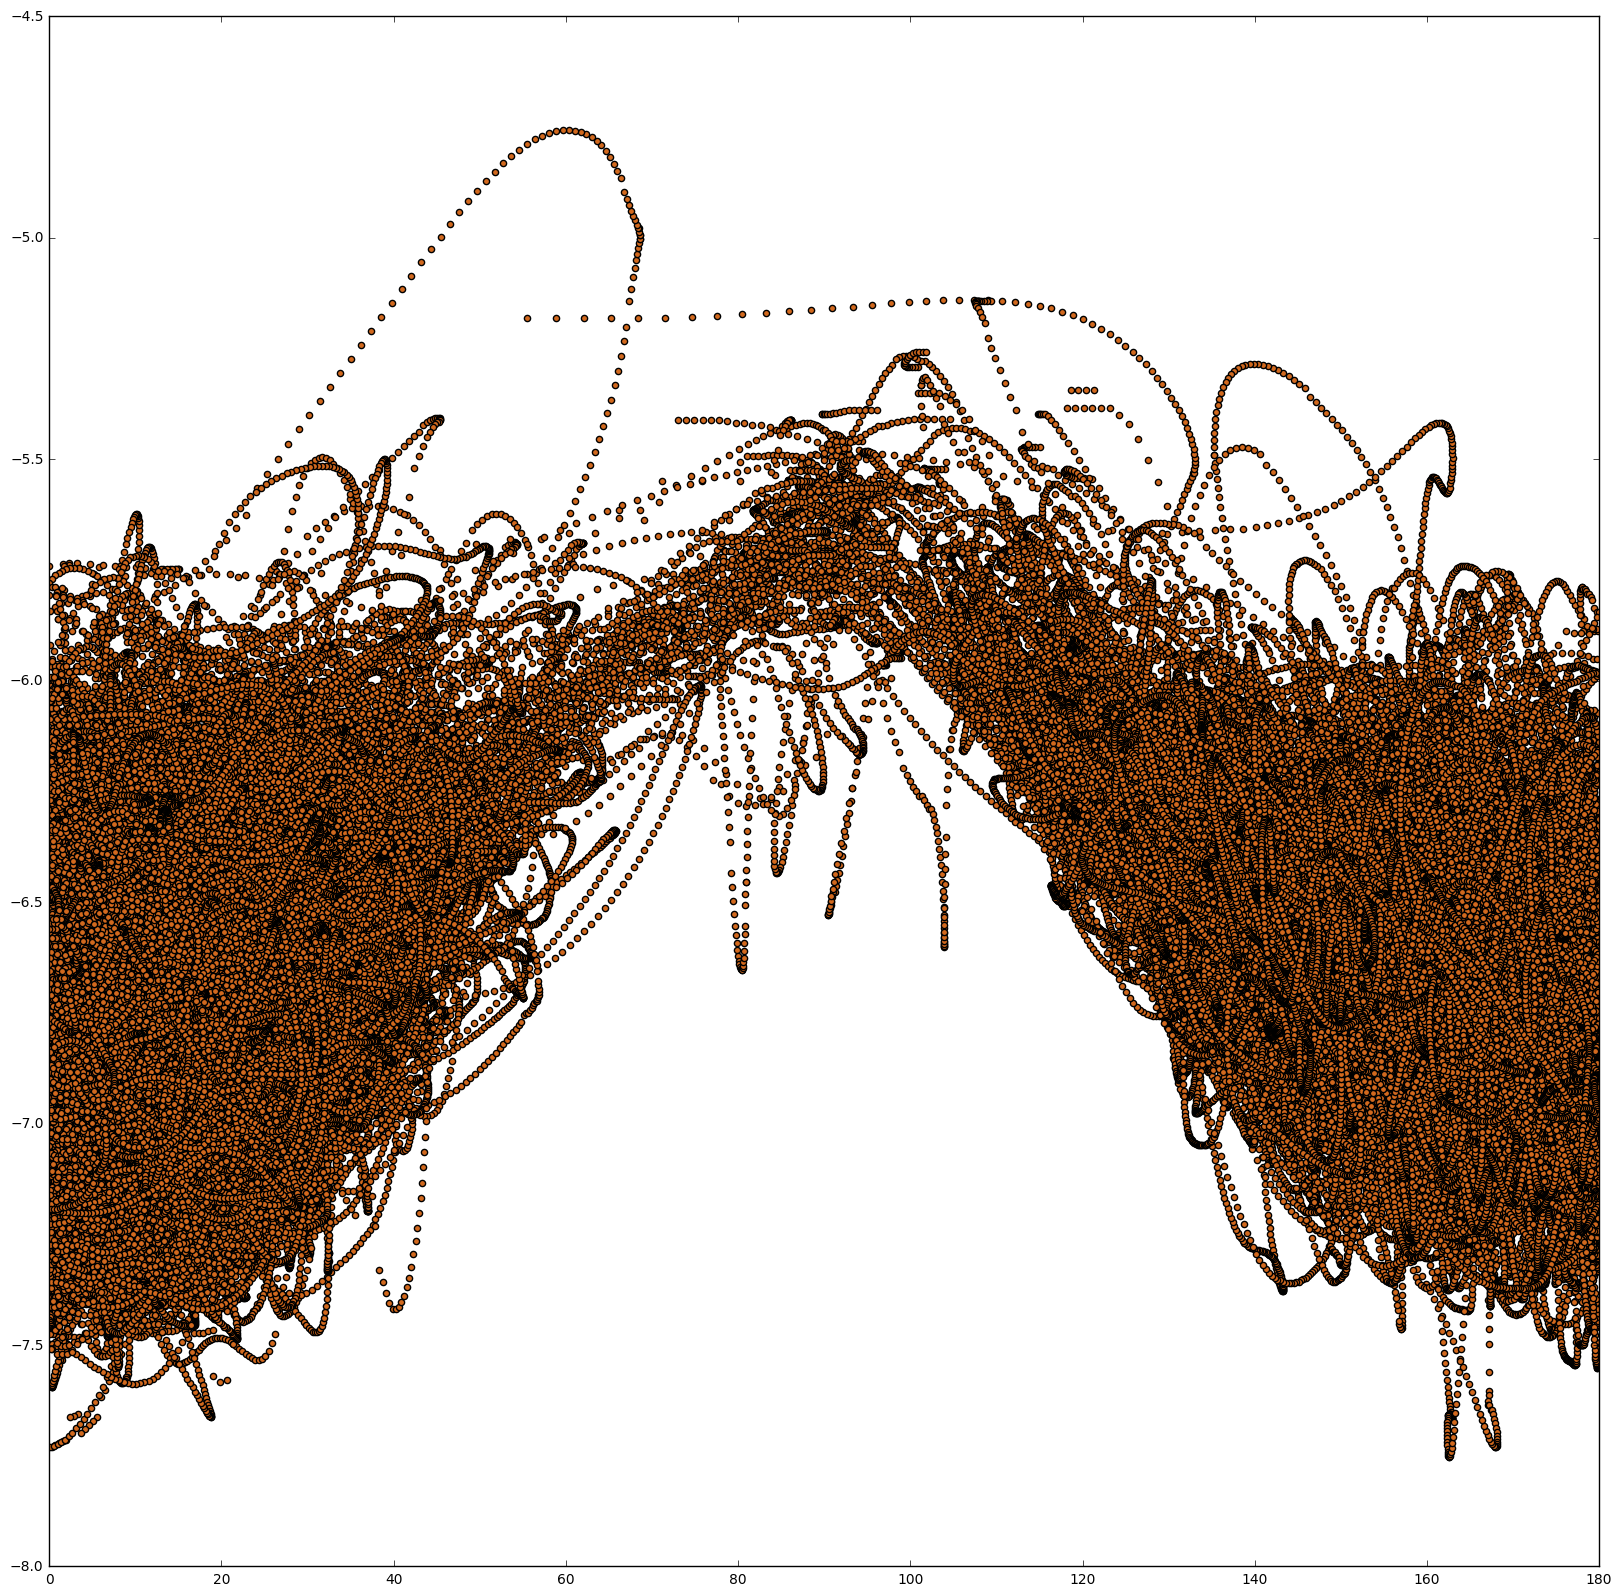

In [24]:
colors = ['#00FFFF','#7FFFD4','#F5F5DC', '#FFE4C4','#FFEBCD','#0000FF','#8A2BE2','#A52A2A','#DEB887','#5F9EA0','#7FFF00','#D2691E','#FF7F50','#6495ED','#DC143C','#00FFFF','#00008B','#008B8B','#B8860B','#A9A9A9','#006400','#BDB76B','#8B008B','#556B2F','#FF8C00','#9932CC','#8B0000','#E9967A','#8FBC8F','#483D8B','#2F4F4F','#00CED1','#9400D3','#FF1493','#00BFFF','#696969','#1E90FF','#B22222','#228B22','#FF00FF','#DCDCDC','#FFD700','#DAA520','#808080','#008000','#ADFF2F','#FF69B4','#CD5C5C','#F0E68C','#7CFC00','#FFFACD','#ADD8E6','#F08080','#FAFAD2','#90EE90','#D3D3D3','#FFB6C1','#FFA07A','#20B2AA','#87CEFA','#778899','#B0C4DE','#FFFFE0','#00FF00','#32CD32','#FF00FF','#800000','#66CDAA','#0000CD','#BA55D3','#9370DB','#3CB371','#7B68EE','#00FA9A','#48D1CC','#C71585','#191970','#FFE4B5','#FFDEAD','#000080','#808000','#6B8E23','#FFA500','#FF4500','#DA70D6','#EEE8AA','#98FB98','#AFEEEE','#DB7093','#FFEFD5','#FFDAB9','#CD853F','#FFC0CB','#DDA0DD','#B0E0E6','#800080','#FF0000','#BC8F8F','#4169E1','#8B4513','#FA8072','#FAA460','#2E8B57','#A0522D','#C0C0C0','#87CEEB','#6A5ACD','#708090','#00FF7F','#4682B4','#D2B48C','#008080','#D8BFD8','#FF6347','#40E0D0','#EE82EE','#F5DEB3','#FFFF00','#9ACD32']
plt.figure(1,figsize=(20,20))
plt.scatter(X[:,4],Y_HOMO_RLX,c=colors[11])
plt.xlim(0,180)
plt.show()

#### Problem
To generate the new data points after regression we chose 4000 random points from the uniform distribution from minimum and maximum of each feature. As we saw previously the transition has a bottle neck around 90 degrees of the dihedral(expected in any transition state). At this point one can expect that choosing a data points from a uniform distribution will broaden the bottle neck, which is not consistent with the original data. Moreover, the data around the bottle neck is very compact and we should not expect the regressor to give a correct answer. To Solve this problem we have to options again

1. To find the joint distribution function of all the features and select 4000 random numbers from that distribution
2. Pospone the regression part until after clustering. after clustering is performed on data, we can use the centroid as the data points to feed the desired regressor and get the smoothen energy values.

To find a distribution function we need to find a 7 dimensional histogram which will bring us back to the original problem of creating a mesh with $10^7$ elements. We will pospone this process to future.
    


# Network
We have 2500 different data points with different energies, the goal is to be able to predict the minimum energy pathway that connects two different data points. To do this we will make each data point a node in a network graph and using some algorithm we can decide whether there exists an edge between two nodes. The edges can be weighted using the energy difference of the data points.
To determine the existance of an edge between two nodes we can either use a distance threshold or we can use the employ k-nearest neighbor methods.

    

# Regression or clustering?
The dimensions has been reduced to 8 from 116. At this point we have two options:

1. One can use a regression method to get a prediction of the whole energy surface and use that to find the minimum energy path which connects two points on that surface to each other. The regression can be chosen from the variaity or different regressors provided by computer science such as kNeighresr neighbors regression, support vector machine regression, neural network regression and etc. 
2. One can try to reduce the data points using different clustering methods such as K-means, .... These clustering methods will try to find the data points which are similar to each other. After that we can use an average over coordinate space and energy space for each cluster to have different data points in the space, which can be used to calculate minimum energy pathway from one of these points to another.

In this work we will explore both and compare the results.


In [25]:
import networkx as nx
import scipy.sparse
from sklearn.neighbors import kneighbors_graph

In [26]:
connectivity = kneighbors_graph(X, 50, mode='connectivity', include_self=False)

In [27]:
G = nx.from_scipy_sparse_matrix(connectivity,create_using=nx.DiGraph())

In [28]:
new_MI = np.array([ 0.09719257,  0.10492396,  0.13380462,  0.13790951,  0.24386509])
#new_MI = mutual_info_regression(X, Y_HOMO_RLX)

In [29]:
new_MI

array([ 0.09719257,  0.10492396,  0.13380462,  0.13790951,  0.24386509])

In [30]:
pos = {}
for inode in range(len(X)):
    pos[inode] = (X[inode,4],Y_HOMO_RLX[inode])

In [31]:
for n,p in pos.items():
    G.node[n]['pos']=p

In [32]:
edges = G.edges()
faulty = []
threshold = np.sqrt(np.dot(new_MI,np.square(np.array([4,4,4,4,4]))))
for iedge in range(len(edges)):
    nn = edges[iedge][1]
    n = edges[iedge][0]
    deltaE = (Y_HOMO_RLX[nn]-Y_HOMO_RLX[n])
    deltaX = np.sqrt(np.dot(new_MI,np.square(X[nn]-X[n])))*np.sign(np.dot(new_MI,X[nn]-X[n]))
    w = np.exp(deltaE/deltaX)
    #w = np.exp(deltaE)
    if (abs(deltaE) > 0.075) or (deltaX>threshold):
        faulty.append((n,nn))
    G.edge[n][nn]['weight'] = w

In [33]:
G.remove_edges_from(faulty)

In [34]:
cons_test = np.zeros((G.number_of_edges(),2))

In [35]:
#pos = nx.get_node_attributes(G,'pos')
#plt.figure(1,figsize=(15,15))
#nx.draw_networkx(G,pos,node_size=10,with_labels=False)
#plt.xlim(0,180)
#plt.savefig("net.png")
#plt.show()


In [39]:
ndata = len(X)
path = nx.dijkstra_path(G,source=ndata-2,target=ndata-1)
#path = nx.shortest_path(G,source=ndata-2,target=ndata-1)#,weight='weight')
print(path)

[331144, 240111, 301266, 288001, 300946, 300943, 325231, 240094, 188268, 188265, 188262, 188259, 188256, 188253, 197593, 197588, 197583, 197577, 197575, 197572, 239660, 239648, 263135, 263142, 263148, 263152, 284216, 284219, 152748, 152728, 152706, 152699, 152691, 152677, 286805, 286814, 315757, 315717, 315693, 196652, 196645, 196640, 196636, 196633, 196627, 196610, 196595, 10198, 10210, 10230, 279239, 279584, 279233, 279589, 331145]


In [37]:
#path = nx.dijkstra_path(G,source=7000,target=17000)
#path = nx.bidirectional_dijkstra(G,target=ndata-2,source=ndata-1)[1]

In [38]:
path = nx.shortest_path(G,source=ndata-2,target=ndata-1)

In [37]:
path[9]

188265

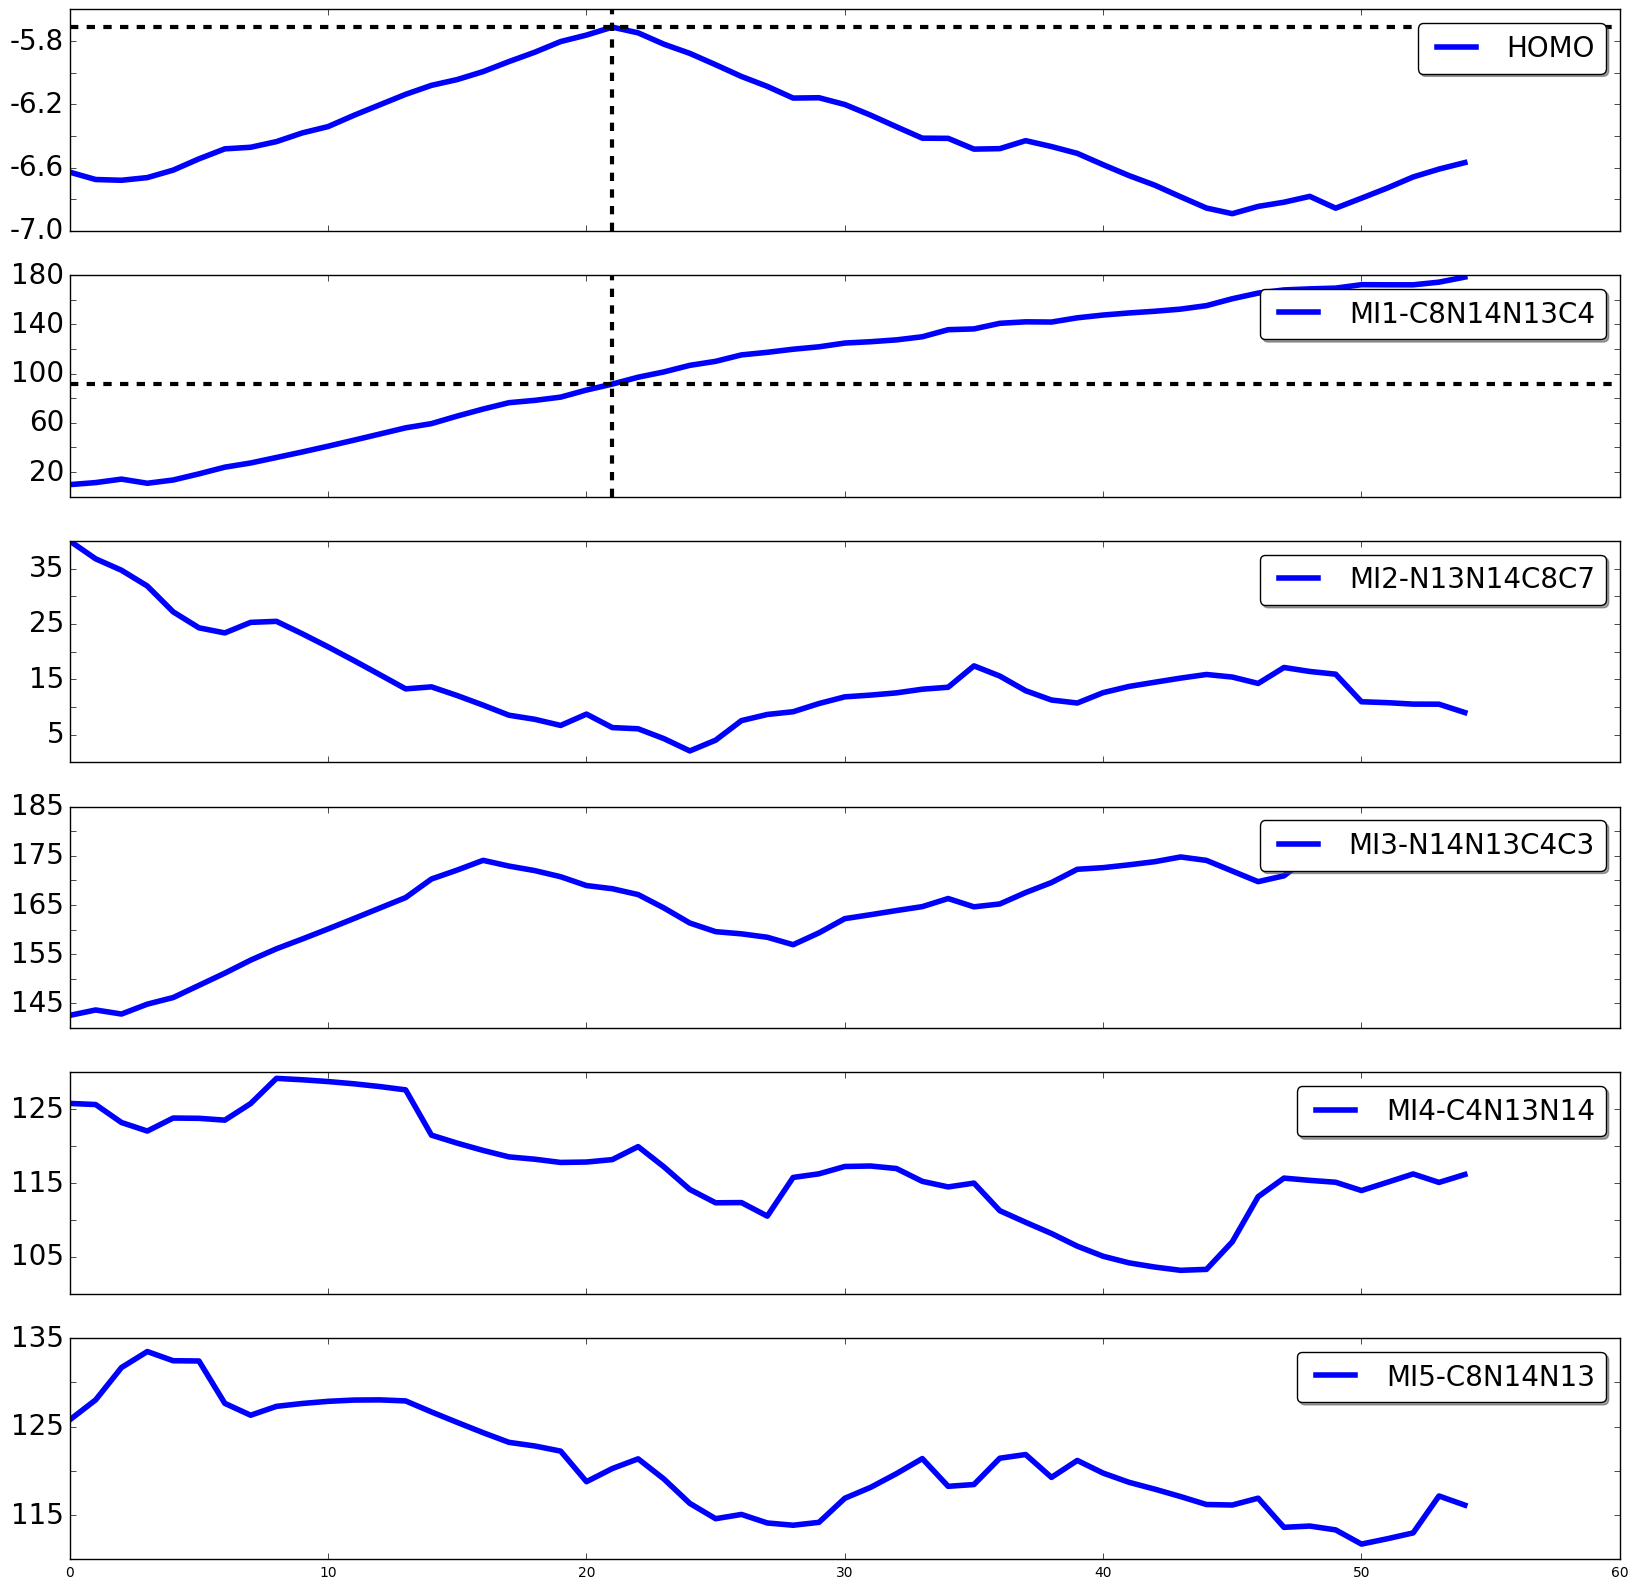

In [38]:
w = []
for inode in range(len(path)-1):
    w.append(G.edge[path[inode]][path[inode+1]]['weight'])
sEN_MAX = np.argmin(-1*Y_HOMO_RLX[path])

#X[path,0].reshape(-1,1).shape

#plt.figure(2,figsize=(10,10))
f,ax = plt.subplots(6,sharex=True,figsize=(20,20))
ax[1].plot(X[path,4],label="MI1-"+f5[0].decode("utf-8"),linewidth=4)
#ax[1].set_title("MI1-"+f5[0].decode("utf-8"),fontsize=20)
ax[1].axvline(x=EN_MAX, color='k', linestyle='--',linewidth=3)
ax[1].set_yticklabels([' ','20',' ','60',' ','100',' ','140',' ','180'], fontsize = 20)
ax[1].axhline(y=X[path,4][EN_MAX], color='k', linestyle='--',linewidth=3)
ax[1].legend(fontsize=20,shadow=True, fancybox=True)
ax[2].plot(pca4.inverse_transform(X[path,3].reshape(-1,1))[:,1],label="MI2-"+f4[0].decode("utf-8"),linewidth=4)
#ax[2].set_title("MI2-"+f4[0].decode("utf-8"),fontsize=20)
ax[2].set_yticklabels([' ','5',' ','15',' ','25',' ','35',' '], fontsize = 20)
ax[2].legend(fontsize=20,shadow=True, fancybox=True)
ax[3].plot(pca3.inverse_transform(X[path,2].reshape(-1,1))[:,1],label="MI3-"+f3[0].decode("utf-8"),linewidth=4)
#ax[3].set_title("MI3-"+f3[0].decode("utf-8"),fontsize=20)
ax[3].set_yticklabels([' ','145',' ','155',' ','165',' ','175',' ','185'], fontsize = 20)
ax[3].legend(fontsize=20,shadow=True, fancybox=True)
ax[4].plot(X[path,1],label="MI4-"+f2[0].decode("utf-8"),linewidth=4)
#ax[4].set_title("MI4-"+f2[0].decode("utf-8"),fontsize=20)
ax[4].set_yticklabels([' ','105',' ','115',' ','125',''], fontsize = 20)
ax[4].legend(fontsize=20,shadow=True, fancybox=True)
ax[5].plot(X[path,0],label="MI5-"+f1[0].decode("utf-8"),linewidth=4)
#ax[5].set_title()
ax[5].legend(fontsize=20,shadow=True, fancybox=True)
ax[5].set_yticklabels([' ','115',' ','125',' ','135'], fontsize = 20)
ax[0].plot(Y_HOMO_RLX[path],label="HOMO",linewidth=4)
#ax[0].set_title(,fontsize=15)
ax[0].legend(fontsize=20,shadow=True, fancybox=True)
ax[0].axvline(x=EN_MAX, color='k', linestyle='--',linewidth=3)
ax[0].axhline(y=Y_HOMO_RLX[path][EN_MAX], color='k', linestyle='--',linewidth=3)
ax[0].set_yticklabels([-7.0,' ',-6.6,' ',-6.2,' ',-5.8,' '], fontsize = 20)
#ax[6].plot(w)
#ax[6].set_title("weights")
#plt.plot(pca1.inverse_transform(X[path,0])[0],Y_HOMO_RLX[path])
plt.savefig("plot0.png")
plt.show()

In [ ]:
w = []
for inode in range(len(path)-1):
    w.append(G.edge[path[inode]][path[inode+1]]['weight'])
f,ax = plt.subplots(2,sharex=True,figsize=(20,20))
EN_MAX = np.argmin(-1*Y_HOMO_RLX[path])

ax[1].plot(X[path,4],label=f5[0].decode("utf-8"),linewidth=4)
ax[1].plot(pca4.inverse_transform(X[path,3].reshape(-1,1))[:,1],label=f4[0].decode("utf-8"),linewidth=4)
ax[1].plot(pca3.inverse_transform(X[path,2].reshape(-1,1))[:,1],label=f3[0].decode("utf-8"),linewidth=4)
ax[1].plot(X[path,1],label=f2[0].decode("utf-8"),linewidth=4)
ax[1].plot(X[path,0],label=f1[0].decode("utf-8"),linewidth=4)
ax[1].legend(fontsize=20,loc=(30,80))
ax[1].yaxis.set_ticks(np.arange(0,190,20))
ax[1].set_ylim(0,180)
ax[1].tick_params(labelsize=20)
ax[0].plot(Y_HOMO_RLX[path],label="HOMO",linewidth=4)
ax[0].legend(fontsize=20)
ax[0].tick_params(labelsize=20)

plt.savefig("plot3.png")
plt.show()

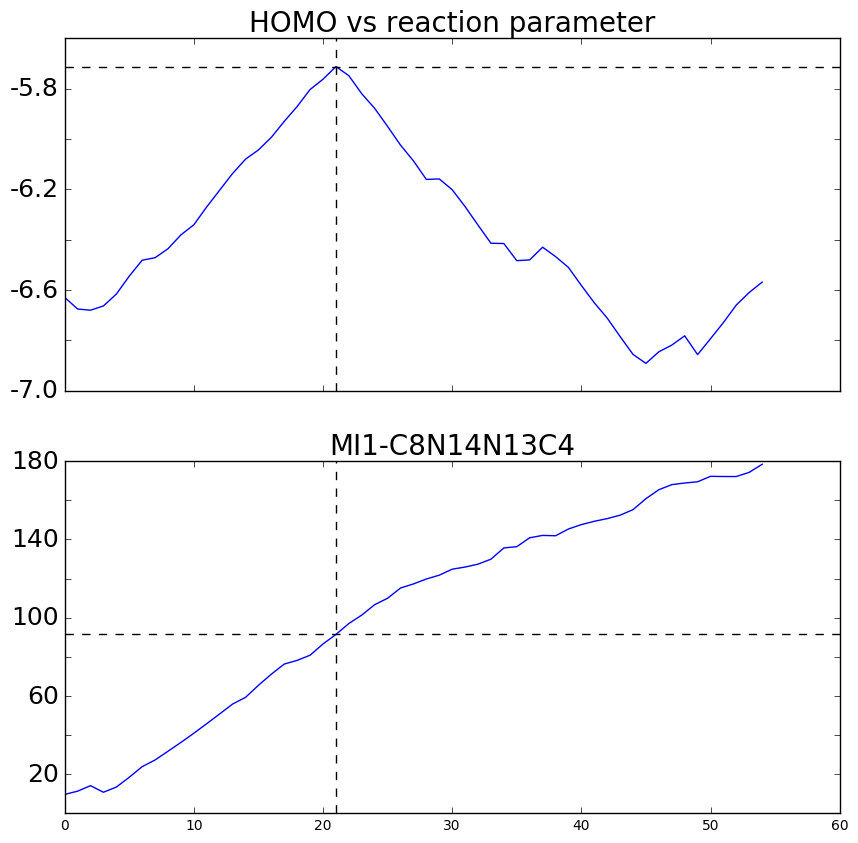

21


In [62]:
w = []
for inode in range(len(path)-1):
    w.append(G.edge[path[inode]][path[inode+1]]['weight'])
EN_MAX = np.argmin(-1*Y_HOMO_RLX[path])

#X[path,0].reshape(-1,1).shape

#plt.figure(2,figsize=(10,10))
f,ax = plt.subplots(2,sharex=True,figsize=(10,10))
ax[1].plot(X[path,4])
ax[1].set_title("MI1-"+f5[0].decode("utf-8"),fontsize=20)
ax[1].axvline(x=EN_MAX, color='k', linestyle='--')
ax[1].axhline(y=X[path,4][EN_MAX], color='k', linestyle='--')
ax[1].set_yticklabels([' ','20',' ','60',' ','100',' ','140',' ','180'], fontsize = 18)
ax[0].set_yticklabels([-7.0,' ',-6.6,' ',-6.2,' ',-5.8,' '], fontsize = 18)
ax[0].plot(Y_HOMO_RLX[path])
ax[0].set_title("HOMO vs reaction parameter",fontsize=20)
ax[0].axvline(x=EN_MAX, color='k', linestyle='--')
ax[0].axhline(y=Y_HOMO_RLX[path][EN_MAX], color='k', linestyle='--')

#ax[0].plot(Y_LUMO_RLX[path])
#ax[0].set_title("LUMO",fontsize=20)
#ax[0].axvline(x=EN_MAX, color='k', linestyle='-')
#ax[0].axhline(y=Y_LUMO_RLX[path][EN_MAX], color='k', linestyle='-')


#plt.plot(pca1.inverse_transform(X[path,0])[0],Y_HOMO_RLX[path])
plt.savefig("plot1.png")
plt.show()
print(EN_MAX)

In [1]:
i = 0
edges = G.edges()
for iedge in range(len(edges)):
    nn = edges[iedge][1]
    n = edges[iedge][0]
    cons_test[iedge,0] = np.sqrt(np.dot(new_MI,np.square(X[nn]-X[n])))
    cons_test[iedge,1] = G.edge[n][nn]['weight'] 

NameError: name 'G' is not defined

In [ ]:
plt.figure(3,figsize=(15,15))
plt.scatter(cons_test[:,0],cons_test[:,1],s=0.5)
plt.xlabel("distance")
plt.ylabel("weight")
plt.show()

In [2]:
x = np.linspace(0, 1)

# Plot the lines y=x**n for n=1..4.
ax = plt.subplot(2, 1, 1)
for n in range(1, 5):
    plt.plot(x, x**n, label="n={0}".format(n))
plt.legend(loc="upper left", bbox_to_anchor=[0, 1],
           ncol=2, shadow=True, title="Legend", fancybox=True)
ax.get_legend().get_title().set_color("red")

# Demonstrate some more complex labels.
ax = plt.subplot(2, 1, 2)
plt.plot(x, x**2, label="multi\nline")
half_pi = np.linspace(0, np.pi / 2)
plt.plot(np.sin(half_pi), np.cos(half_pi), label=r"$\frac{1}{2}\pi$")
plt.plot(x, 2**(x**2), label="$2^{x^2}$")
plt.legend(shadow=True, fancybox=True)

plt.show()

NameError: name 'np' is not defined

In [ ]:
plt.plot(X[path,4],Y_HOMO_RLX[path])
#plt.plot(X[path,2],Y_LUMO_RLX[path])
plt.show()

In [ ]:
from sklearn.cluster import AgglomerativeClustering

In [ ]:
ward = AgglomerativeClustering(n_clusters=20000, connectivity=connectivity,linkage='ward').fit(X)
label1 = ward.labels_


In [ ]:
maxi = np.array([0.0,0.0,0.0])
idx = np.array([0,0,0])
for i in range(50000):
#    if i == 39760 or i == 39479 or i == 39265 : 
#        print(X[label1==i],i)
    for j in range(3):
        test = X[label1 == i,j]
        if len(test) == 0:
            continue
        R = max(test) - min(test)
        if R>maxi[j]:
            maxi[j] = R
            idx[j] = i
print(maxi)
print(idx)

In [ ]:
plt.figure(1,figsize=(10,10))
for i in range(200):
    plt.scatter(X[label1 == i,2],Y_HOMO_RLX[label1 == i],c=colors[i%len(colors)])
plt.xlim(0,180)
plt.show()

In [ ]:
ncluster = 20000
X_new = np.zeros((ncluster,3))
Y_new = np.zeros((ncluster,))
for icent in range(ncluster):
    cond = label1 == icent
    if np.all(np.logical_not(cond)) :
        continue
    X_new[icent,:] = np.average(X[cond],0)[:]
    Y_new[icent] = np.average(Y_HOMO_RLX[cond])

In [ ]:
X_new = np.vstack((X_new,INIT))
Y_new = np.append(Y_new,knn_fit.predict(INIT))
X_new = np.vstack((X_new,FIN))
Y_new = np.append(Y_new,knn_fit.predict(FIN))
print(X_new.shape,Y_new.shape)

In [ ]:
connectivity_new = kneighbors_graph(X_new, 5, mode='connectivity', include_self=False)
G = nx.from_scipy_sparse_matrix(connectivity_new,create_using=nx.DiGraph())
pos = {}
for inode in range(len(X_new)):
    pos[inode] = (X_new[inode,2],Y_new[inode])
for n,p in pos.items():
    G.node[n]['pos']=p
for n,p in G.edge.items():
    for nn,pp in p.items():
        G.edge[n][nn]['weight'] = Y_new[nn]-Y_new[n]
        #G.edge[n][nn]['weight'] = abs(Y_HOMO_RLX[nn]-Y_HOMO_RLX[n])

In [ ]:
pos = nx.get_node_attributes(G,'pos')
plt.figure(1,figsize=(15,15))
nx.draw_networkx(G,pos,node_size=10,with_labels=False)
plt.show()

In [ ]:
ndata = len(X_new)
path = nx.dijkstra_path(G,source=ndata-2,target=ndata-1)
#path = nx.shortest_path(G,source=ndata-2,target=ndata-1,weight='weight')
print(path)

In [ ]:
w = []
for inode in range(len(path)-1):
    w.append(G.edge[path[inode]][path[inode+1]]['weight'])

#X[path,0].reshape(-1,1).shape

#plt.figure(2,figsize=(10,10))
f,ax = plt.subplots(5,sharex=True,figsize=(20,20))
ax[0].plot(X_new[path,2])
ax[0].set_title("MI1")
ax[1].plot(pca2.inverse_transform(X_new[path,1].reshape(-1,1))[:,1])
ax[1].set_title("MI2")
ax[2].plot(pca1.inverse_transform(X_new[path,0].reshape(-1,1))[:,1])
ax[2].set_title("MI3")
ax[3].plot(Y_new[path])
ax[3].set_title("HOMO")
ax[4].plot(w)
ax[4].set_title("weights")
#plt.plot(pca1.inverse_transform(X[path,0])[0],Y_HOMO_RLX[path])
plt.show()

In [ ]:
plt.plot(X_new[path,2],Y_new[path])
#plt.plot(X[path,2],Y_LUMO_RLX[path])
plt.show()

In [ ]:
Gp = nx.Graph()
ndata = len(X)
for idata in range(ndata):
    Gp.add_node(idata,pos=(X[idata,2],Y_HOMO_RLX[idata]))
Gp.add_edge(ndata-2,path[0])
for inode in range(len(path)-1):
    Gp.add_edge(path[inode],path[inode+1])
Gp.add_edge(path[-1],ndata-1)

In [ ]:
pos = nx.get_node_attributes(Gp,'pos')
plt.figure(1,figsize=(20,20))
nx.draw_networkx(Gp,pos,node_size=7,with_labels=False)
plt.show()

In [ ]:
threshold = np.linalg.norm(np.ones_like(X[0])*mi_RLX[mi_RLX > 0.179])
ar_thresh = np.arange(1,10)*threshold
ndata = len(X)
edge_list = []
for it in range(len(ar_thresh)):
    edge_list.append([])
for idata in range(ndata):
    for jdata in range(idata):
        diff = np.linalg.norm(abs(X[idata]-X[jdata])*mi_RLX[mi_RLX > 0.179])
        for it in range(len(ar_thresh)):
            if diff < ar_thresh[it] : 
#                w = (Y[jdata]-Y[idata])/diff
                edge_list[it].append((idata,jdata,w))
                edge_list[it].append((jdata,idata,-1*w))


In [ ]:
edge_list2[0]

In [ ]:
edge_list2 = []
for it in range(len(edge_list)):
    edge_list2.append(np.array(edge_list[it]))

In [ ]:
for it in range(len(edge_list2)):
    edge_list2[it][:,2] = edge_list2[it][:,2]-min(edge_list2[it][:,2])

In [ ]:
min(edge_list2[0][:,2])

In [ ]:
G.add_weighted_edges_from(edge_list2[5])
nx.number_of_edges(G) 

In [ ]:
pos = nx.get_node_attributes(G,'pos')
plt.figure(1,figsize=(15,15))
nx.draw_networkx(G,pos,node_size=10,with_labels=False)
plt.show()

In [ ]:
a = nx.all_simple_paths(G, source=ndata-2, target=ndata-1)

In [ ]:
for p in a:
    print(a)

In [ ]:
ndata
path = nx.dijkstra_path(G,source=ndata-2,target=ndata-1)
#path = nx.shortest_path(G,source=ndata-2,target=ndata-1,weight='weight')
print(path)

In [ ]:
ndata
path = nx.bidirectional_dijkstra(G,source=ndata-2,target=ndata-1)[1]
#path = nx.shortest_path(G,source=ndata-2,target=ndata-1)
print(path)

In [ ]:
Gp = nx.Graph()
ndata = len(X)
for idata in range(ndata):
    Gp.add_node(idata,pos=(X[idata,6],Y[idata]))

In [ ]:
Gp.add_edge(ndata-2,path[0])
for inode in range(len(path)-1):
    Gp.add_edge(path[inode],path[inode+1])
Gp.add_edge(path[-1],ndata-1)

In [ ]:
pos = nx.get_node_attributes(Gp,'pos')
plt.figure(1)
nx.draw_networkx(Gp,pos,node_size=10,with_labels=False)
plt.show()

In [ ]:
plt.plot(Y[path])
plt.show()

In [ ]:
cum_w = []
cum_y = []
for inode in range(len(path)-1):
    cum_w.append(G.edge[path[inode]][path[inode+1]]['weight'])
    cum_y.append(Y[path[inode+1]]-Y[path[inode]])
plt.plot(cum_w,label='we')
#plt.plot(cum_y,label='y')
plt.legend()
plt.show()

In [ ]:
plt.plot(X[path])
plt.show()

In [ ]:
from scipy.interpolate import interp1d

In [ ]:
f2 = interp1d(X[path,6],Y[path],kind='nearest')

In [ ]:
xnew=np.linspace(10,177,num=20)
plt.plot(X[path,6],Y[path],'o',xnew,f2(xnew))
plt.show()

In [ ]:
X

## Clustering
The are differnt clustering methods that can be performed on this data such as Kmeans, Affinity Propagation, MeanShift, Spectral Clustering, Birch, DBscan and etc. Most common method used in data analysis is Kmeans clustering. We habe chosen 2800 clusters.
Scikit learns Kmeans package offers a multiprocessing method for kmeans which will make the analysis vary fast.


In [ ]:
from sklearn.cluster import KMeans

In [ ]:
ncluster = 7000
kmeans = KMeans(n_clusters=ncluster,random_state=0).fit(X)

In [ ]:
plt.figure(1,figsize=(15,15))
for i in range(7000):
    plt.scatter(X[kmeans.labels_ == i,2],X[kmeans.labels_ == i,0],c=colors[i%len(colors)])
plt.xlim(0,180)
plt.show()

As we can see kmens is doing a good job but to increase the accuracy we can help the algorithm by adding the mapped space (energy) to X matrix.

In [ ]:
ndata , nfeature = X_reduced.shape
FULL = np.zeros((ndata,nfeature+1))
for ifeat in range(nfeature):
    FULL[:,ifeat] = X_reduced[:,ifeat]
FULL[:,nfeature] = Y_HOMO_RLX[:]

In [ ]:
ncluster = 2500
kmeans = KMeans(n_clusters=ncluster,n_jobs = -1,random_state=0).fit(FULL)

In [ ]:
plt.figure(1,figsize=(15,15))
for i in range(2800):
    plt.scatter(FULL[kmeans.labels_ == i,0],FULL[kmeans.labels_ == i,7],c=colors[i%len(colors)])
plt.xlim(0,180)
plt.show()

Next stop is to find the centroids and reduce the data from total data points to total number of cluster

In [ ]:
X_new = np.zeros((ncluster,7))
FULL_new = np.zeros((ncluster,8))
Y_new_HOMO = np.zeros((ncluster,))
Y_new_LUMO = np.zeros((ncluster,))
for idata in range(ncluster):
    X_new[idata] = np.average(X_reduced[kmeans.labels_==idata],0)
    FULL_new[idata] = np.average(FULL[kmeans.labels_ == idata],0)
    Y_new_HOMO[idata] = np.average(Y_HOMO_RLX[kmeans.labels_==idata])
    Y_new_LUMO[idata] = np.average(Y_LUMO_RLX[kmeans.labels_==idata])
    

In [ ]:
plt.figure(2,figsize=(15,15))
plt.scatter(X_new[:,6],Y_new_HOMO,c=colors[11])
plt.show()

So far we have reduced our data from (66000,116) to (2500,7). Because the molecule spends very little time around the bottle neck the amount of data we have in this region is very small. Using clustering will even decrease the data points in those areas too. The best method is to use a mesh if possible. In this work we will use both and compare the results

# Clustering using k Nearest Neighbors


In [ ]:
from reduce_data import reduce_data

In [ ]:
FULL = np.zeros((ndata,nfeature+1))
for ifeat in range(nfeature):
    FULL[:,ifeat] = T[:,ifeat]
FULL[:,nfeature] = y_predict[:]

In [ ]:
nloop = 0
nreduction = 10000
thresh = np.ones_like(T[0])
R = np.linalg.norm(thresh)
while len(T) > nreduction and nloop < 10:
    ndata = len(T)
    idata = np.random.randint(ndata,size=1)
    results = np.zeros((ndata,))
    for jdata in range(ndata):
        if np.linalg.norm(T[idata]-T[jdata]) <= R :
            results[jdata] = 1
        else : 
            results[jdata] = 0
    nreduce = sum(results)
    if nreduce == 0 :
        nloop += 1
        continue
    new_T = T[results == 0]
    adding_data = np.average(T[results == 1],axis=0)
    new_T = np.vstack((new_T,adding_data))
    T = new_T
    


In [ ]:
T.shape
nloop

In [ ]:
plt.figure(1,figsize=(20,20))
plt.scatter(T[:,6],knn_fit.predict(T))
plt.show()

In [ ]:

FULL[:,nfeature] = Y_HOMO_RLX[:]
thresh = np.ones_like(FULL[0])
thresh[nfeature] = 0.1
new_FULL = reduce_data(FULL,np.linalg.norm(thresh),10000,4)

In [ ]:
from sklearn.neighbors import NearestNeighbors

In [ ]:
nbrs = NearestNeighbors(n_neighbors=10, algorithm='ball_tree',metric='euclidean').fit(T)
distances, indices = nbrs.kneighbors(T)


In [ ]:
thresh = np.linalg.norm(np.ones_like(T[0]))
ndata = len(T)
deleted = []
count = 0
for i in range(10):
    if np.any(indices[i] == deleted) : 
        continue
    else :
        if sum(distances[i]) <= thresh*5 :
            deleted = np.append(deleted,indices[i])
            count += 1
        else :
            count += 1
print(count)
print(deleted)